# A first look at the data

## Google colab block (copy and paste these blocks so it works on colab)

In [ ]:
# mount the drive (you'll have to click through the popup to allow it)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/'GripS MEG'/Data/COGITATE/  # for others the path will likely be under Shared Drive

copy_data.sh		  derivatives	     participants.tsv  sub-CB069
dataset_description.json  participants.json  README.md


In [ ]:
!pip install openneuro-py
!pip install --upgrade mne-bids[full]

## Introduction

In this section the paths to the data will be set such that they can be loaded. This will allow for explaining the data structure and do a few sanity checks. Finally follows some examples for how to perform simples plots of the raw data.

Import the required modules:

In [ ]:
import os
import os.path as op
import openneuro

import numpy as np
import mne
from mne_bids import BIDSPath, read_raw_bids # If you don't have mne_bids installed, comment this line.

## Loading the data

The MEGIN data are stored in the FIF format which is a binary format with embedded labels.

The first step is to set the path to the data as well as the files names. Note that this will dependent on where you have stored the dataset.


### File overview
The chapter relies on the file (embedded in the BIDS structure):
~~~
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif
~~~

### Loading the BIDS data

There are two ways to obtain the data.
1. Run the code below to directly download from openneuro website using their python module.
2. Visit [OpenNeuro](https://openneuro.org/datasets/ds004346/versions/1.0.2) and manually download the data with your browser.

In [ ]:
''' don't follow these if on colab

# 1. Follow these instructions if you are downloading the data directly from openneuro:

dataset = 'ds004346'  # dataset ID in openneuro

# bids_root = r'THE PATH TO WHERE YOU WANT TO DOWNLOAD THE DATA'
bids_root = '/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data'

# download the dataset from openneuro
openneuro.download(dataset=dataset, target_dir=bids_root)

# 2. Follow these instruction if you already have downloaded the data from openneuro to a local directory

# The folder just under bids_root is called sub-01
# Example for Windows
# bids_root = r'C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX'
# Example for MacOS
# bids_root = '/Volumes/jenseno-avtemporal-attention/Projects/FLUX/data'
'''


👋 Hello! This is openneuro-py 2023.1.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds004346 …


📁 Traversing directories for ds004346 : 0 entities [00:00, ? entities/s]

📥 Retrieving up to 358 files (5 concurrent downloads). 
✅ Finished downloading ds004346.
 
🧠 Please enjoy your brains.
 
🔄 Request timed out while downloading /Users/o.jensen@bham.ac.uk/Python/FLUX/Code/FLUX/MNEPython/Z:\FLUX_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_meg.fif, retrying in 0.5 sec …


<div class="alert alert-block alert-danger">
<b>Warning:<br />
    </b> Before proceeding with the tutorial, make sure that the download is complete. This step can be very long, depending on your internet connection speed.

The next step is to prepare the data for reading. This requires creating the mne_bids.BIDSPath which point to the path of MNE-BIDS structure.

In [ ]:
bids_root = 'drive/MyDrive/GripS MEG/Data/COGITATE/'

subject = 'CB069'
session = '1'
task = 'dur'  # name of the task
run = '01'  # we have two runs for this subject, let's look at run = 1
suffix = 'meg'

bids_path = BIDSPath(subject=subject, session=session, task=task, run=run, suffix=suffix, root=bids_root)


deriv_root = op.join(bids_root, 'derivatives/preprocessing')  # output path

deriv_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix='meg', root=deriv_root).mkdir()

deriv_fname = bids_path.basename.replace('meg', 'raw_sss') # output filename
deriv_file_1 = op.join(deriv_path.directory, deriv_fname)+'.fif'
deriv_file_2 = deriv_file_1.replace('run-01', 'run-02')

There is a limit to the file size of the FIF files. If the MEG recordings exceed this limit, the MEGIN acquisition system automatically split the data in two or more FIF files. In those cases, by reading the first FIF file, MNE-Python will automatically read all the linked split files. In this example, the sample dataset was broken into 2 sub-files by the operator and they need to be read one by one.

We now created the BIDSPath object, let's read the first meg file:

In [ ]:
print(bids_path)
raw1 = read_raw_bids(bids_path=bids_path, verbose=False)

drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_meg.fif


<ipython-input-17-b2da5c90231e>:2: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw1 = read_raw_bids(bids_path=bids_path, verbose=False)
<ipython-input-17-b2da5c90231e>:2: RuntimeWarning: Omitted 815 annotation(s) that were outside data range.
  raw1 = read_raw_bids(bids_path=bids_path, verbose=False)
<ipython-input-17-b2da5c90231e>:2: RuntimeWarning: The unit for channel(s) BIO002, BIO003, MISC001, MISC002, MISC003, MISC004, MISC005, MISC006, MISC007, MISC008, MISC009, MISC010 has changed from V to NA.
  raw1 = read_raw_bids(bids_path=bids_path, verbose=False)


## Inspecting at the data

To get some basic information from the FIF file write:

In [ ]:
print(raw1)

<Raw | sub-CB069_ses-1_task-dur_run-01_meg.fif, 404 x 503000 (503.0 s), ~5.3 MB, data not loaded>


The 527 kB refers to the size of the data set. The 1457.0 s is the recording time. As the sampling rate was 1000 Hz, this results in 1457000 samples recorded in 343 channels. These channels include the MEG, EOG, triggers channels etc.

To get some additional information:

In [ ]:
print(raw1.info)

<Info | 25 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: EOG001, BIO002, BIO003, EEG001, EEG002, EEG003, EEG004, EEG005, ...
 chs: 1 EOG, 12 misc, 64 EEG, 11 Internal Active Shielding data (Triux systems), 102 Magnetometers, 204 Gradiometers, 9 Stimulus, 1 System status channel information (Triux systems)
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_head_t: MEG device -> head transform
 dig: 129 items (3 Cardinal, 4 HPI, 65 EEG, 57 Extra)
 events: 1 item (list)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 330.0 Hz
 maxshield: True
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 404
 proc_history: 1 item (list)
 proj_name: mne_anonymize
 projs: generated with autossp-1.0.1: off, ge

This information shows important parameters of the dataset. For instance, the gantry was positioned at 68 degress (*gantry_angle*) and that the sampling frequency was 1000 Hz (*sfreq*). The data were lowpass filtered at 330.0 Hz (*lowpass*) and highpass filtered at 0.1 Hz (*highpass*) prior to the digital sampling. The *experimenter* is anonymized and the recording data is not meaningful as to comply with GDPR rules.


**Question 1:** What is the purpose of the 330 Hz lowpas-filter (hint: see Analog Filters for Data Conversion, Chapter 3; Smith et al., 1999)

**Question 2:** What is the purpose of 0.1 Hz highpass-filter?


The data object (`raw1`) allows for a simple inspection of the data by calculating the spectra:

In [ ]:
n_fft = 2000
data1PSD = raw1.compute_psd(method="welch", fmin=1, fmax=60, picks="meg", n_fft=n_fft, n_overlap=int(n_fft/2))

Effective window size : 2.000 (s)


A standard Welch method is applied here. The data are divided into sections being 2 s long (2000 samples) with a 1 s overlap (1000 samples). This results in a 0.5 Hz resolution Prior to calculating the FFT of each section a Hamming taper is multiplied.

To plot the data write:

Plotting power spectral density (dB=True).


<ipython-input-21-6a855f496aed>:3: RuntimeWarning: (X, Y) fit (0.8, 27.6) more than 20 mm from head frame origin
  data1PSD.plot();
<ipython-input-21-6a855f496aed>:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  data1PSD.plot();


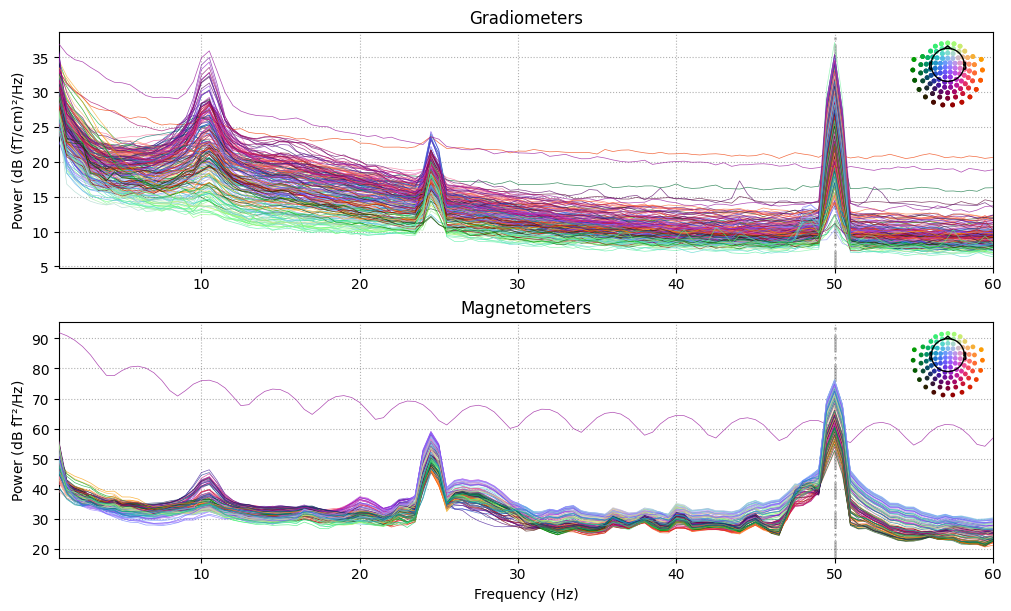

In [ ]:
# The line below enables inline plotting in Jupyter Notebooks, displaying plots below code cells.
%matplotlib inline
data1PSD.plot();

Note the 10 Hz alpha activity in the gradiometers as well as the 50 Hz line noise. The frequency of the line noise is 50 Hz in European countries including Russia whereas it is 60 in South Korea as well as South and North America. In Japan it can be either 50 or 60 Hz depending on the region.

**Question 3:** Why is the line-noise 50 Hz larger for the magnetometers than the gradiometers?


To show the raw data using the interactive functions of the plotting tool write:

Using matplotlib as 2D backend.


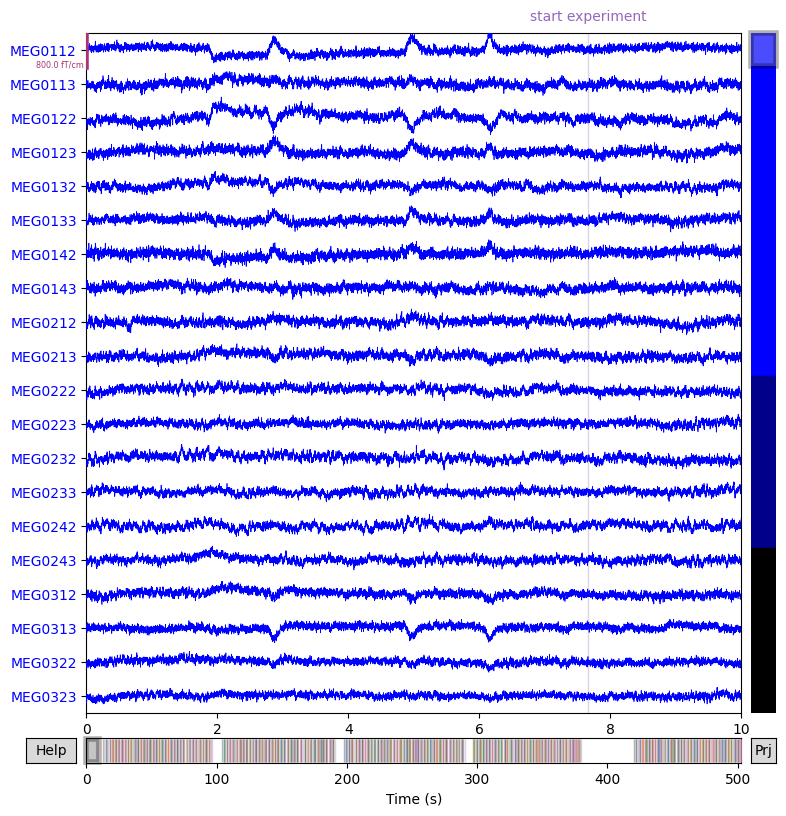

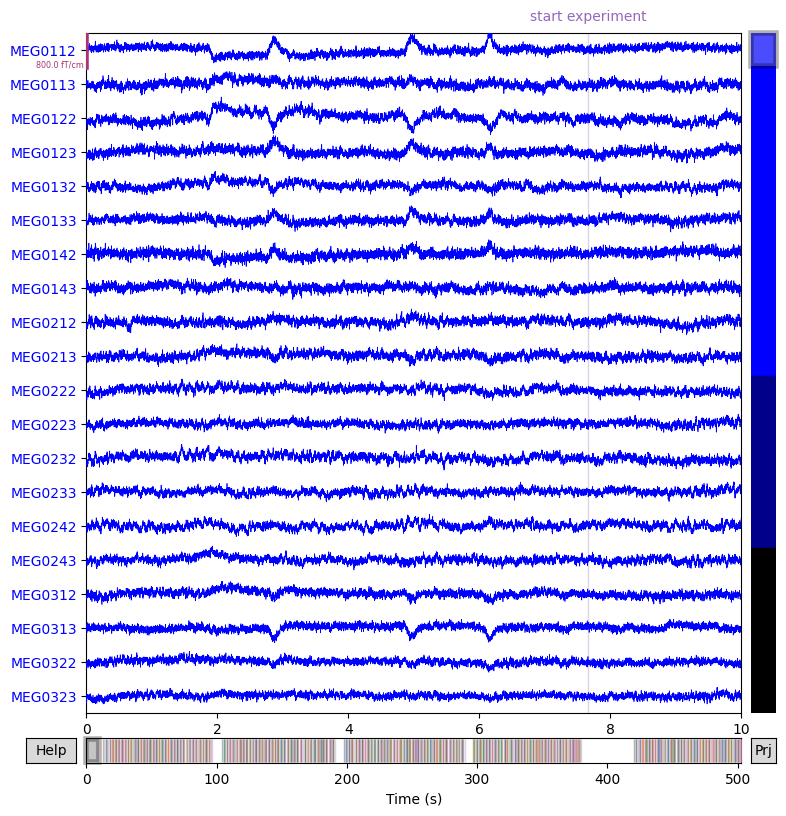

In [ ]:
#%matplotlib qt
raw1.plot(duration=10, title='Raw')

This will open the plot in a new window. Use the arrow keys to move over channels and time. Click on the help button for more information.

**Question 3:** Scroll through the MEG data and identify the following artifacts (include figures in the response):

- Eye-blink
- A muscle contraction (characterized by high-frequency activity)
- The cardiac artifact



## Preregistration and publication

Preregistration: Report the sampling frequency and the properties of the anti-aliasing lowpass filter. Also report the peripheral data to be recorded (e.g. the EOG and ECG).

Publication, example:

"The ongoing MEG data were recorded using the TRIUX system from MEGIN. This system consists of 102 magnetometers and 204 planar gradiometers. Each of the 102 sensor locations has one magnetometer and a set of two orthogonal gradiometers. The horizontal and vertical EOG data, as well as the ECG, were also collected alongside the MEG data. All the data were sampled at 1000 Hz and stored for offline analysis. Prior to sampling, a lowpass filter at ~330 Hz was applied. To record the horizontal EOG, a pair of electrodes were attached approximately 2.5 cm away from the outer canthus of each eye. To record the vertical EOG, a pair of electrodes were placed above and below the right eye in line with the pupil. The ECG was recorded from a pair of electrodes placed on the left and right collarbone. In addition, four head position indicator coils (HPIs) were placed behind the left and right ear, as well as on the left and right forehead just below the hairline. The positions of the HPIs, the nasion, the left and right preauricular points, as well as the surface points of the scalp, were digitized using a Polhemus device."


## References
Smith, W.S. (1997) The Scientist and Engineer's Guide to Digital Signal Processing. California Technical Publishing. ISBN 0-9660176-3-3 [Online version](http://www.dspguide.com/)